# Задание 3. Экстраполяция временных рядов.


Используется предложенный датасет №1 (DataSet1_3).

### Описание каждого значения в наборе данных.


| Столбец | Описание | Тип данных |
|-----------|-----------|-----------|
| Date  | Дата записи данных  | Datetime |
| Open  | Цена акции на момент открытия торгов  | Float  |
| High  | Максимальная цена акции на момент торгов | Float  |
| Low  | Минимальная цена акции на момент торгов  | Float |
| Close  | Цена акции на момент закрытия торгов  | Float  |
| Volume  | Суммарный объём сделок в данную дату | Integer  |
| Name  | Наименование акции | String  |

## Написание кода
### Для начала импортируем все нужные библиотеки и загрузим датасет.

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

df = pd.read_csv('/content/DataSet1_3.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


## Подготовка данных

Возьмём 200 значений для дальнейшей работы и преобразуем столбец "Date", так как на данный момент он находится в формате object, а нам необходим формат datetime.

In [ ]:
n1 = 101
n2 = 300
data = df.iloc[n1:n2].reset_index(drop=True)

# Перевели дату в дни для удобной работы
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Seconds'] = (data['Date'] - data['Date'].iloc[0]).dt.total_seconds() + 1
data['x'] = data['Seconds'] /(24*60*60)
data['x'] -= data['x'].iloc[0] - 1
data.head()


,Date,Open,High,Low,Close,Volume,Name,Seconds,x
0,2006-05-30,189.33,190.69,185.91,186.16,4315930,GOOGL,1.0,1.0
1,2006-05-31,187.09,189.31,183.57,186.10,7982732,GOOGL,86401.0,2.0
2,2006-06-01,186.96,191.69,185.99,191.50,6280223,GOOGL,172801.0,3.0
3,2006-06-02,192.92,193.73,188.91,189.91,6386442,GOOGL,259201.0,4.0
4,2006-06-05,188.28,190.92,187.26,187.41,5559992,GOOGL,518401.0,7.0


#### Модель ARIMA

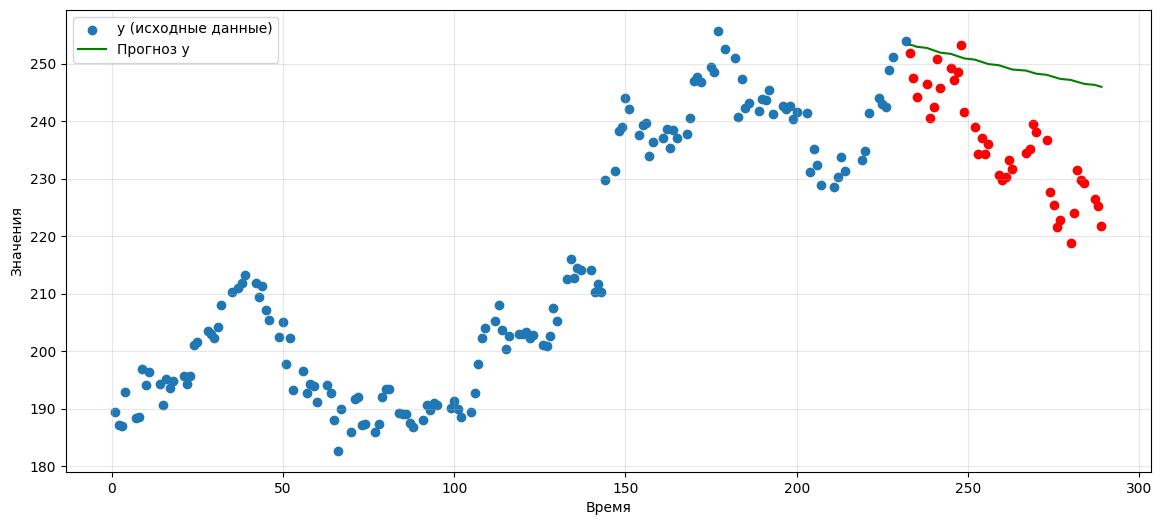

In [ ]:
X = data['x']
Y = data['Open']
# Разделим данные на обучающий и тестовый наборы не перемешивая
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Построим модель ARIMA для временного ряда y
model_y = ARIMA(y_train, order=(2, 0, 0))
results_y = model_y.fit()

# Прогноз для y
forecast_y = results_y.forecast(steps=len(y_test))

# Визуализация
plt.figure(figsize=(14, 6))
plt.scatter(x_train, y_train, label='y (исходные данные)')
plt.scatter(x_test, y_test, color='red')
plt.plot(x_test, forecast_y, label='Прогноз y', color='green')
plt.xlabel('Время')
plt.ylabel('Значения')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#### Модель k-NN

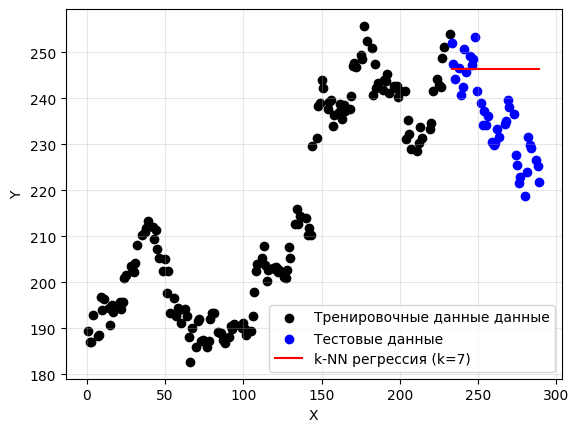

In [ ]:
x = np.array(X).reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2, random_state=42, shuffle=False)


# Создадим модель k-NN регрессии
k = 7
model = KNeighborsRegressor(n_neighbors=k)

# Обучим модель на обучающих данных
model.fit(x_train, y_train)

# Получим предсказания для тестового набора
y_pred = model.predict(x_test)

# Визуализация данных и регрессии
plt.scatter(x_train, y_train, label='Тренировочные данные данные', color='black')
plt.scatter(x_test, y_test, label='Тестовые данные', color='blue')
plt.plot(x_test, y_pred, label=f'k-NN регрессия (k={k})', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

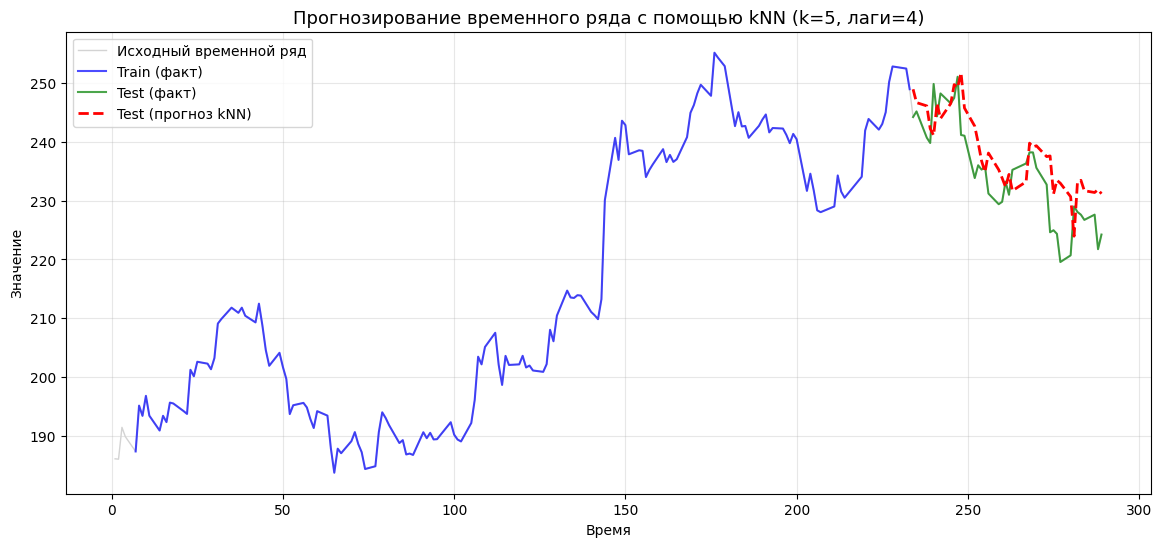

In [ ]:
def create_lagged_features(series, n_lags=5):
    """
    Создаёт датасет, где каждый объект — это n_lags предыдущих значений,
    а целевая переменная — следующее значение.
    """
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])  # предыдущие n_lags значений
        y.append(series[i])             # следующее значение
    return np.array(X), np.array(y)

X = data['x'].reset_index(drop=True)
Y = data['Close'].reset_index(drop=True)

n_lags = 4
X_lag, y_lag = create_lagged_features(Y, n_lags)

split_index = int(0.8 * len(X_lag))

X_train, X_test = X_lag[:split_index], X_lag[split_index:]
y_train, y_test = y_lag[:split_index], y_lag[split_index:]

# Обучение финальной модели
k = 5
model_knn = KNeighborsRegressor(n_neighbors=5, weights='uniform')
model_knn.fit(X_train, y_train)

# Предсказания
y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

# Визуализация исходного ряда и прогноз на тесте
plt.figure(figsize=(14, 6))

# Полный ряд
plt.plot(x, Y, label='Исходный временной ряд', color='lightgray', lw=1)

# Обучающая часть
train_time = x[n_lags:split_index + n_lags]
plt.plot(train_time, y_train, label='Train (факт)', color='blue', alpha=0.7)

# Тестовая часть — факт
test_time = x[split_index + n_lags: split_index + n_lags + len(y_test)]
plt.plot(test_time, y_test, label='Test (факт)', color='green', alpha=0.7)

# Тестовая часть — предсказание
plt.plot(test_time, y_test_pred, label='Test (прогноз kNN)', color='red', linestyle='--', lw=2)

plt.title(f'Прогнозирование временного ряда с помощью kNN (k={k}, лаги={n_lags})', fontsize=13)
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



#### Метод МНК

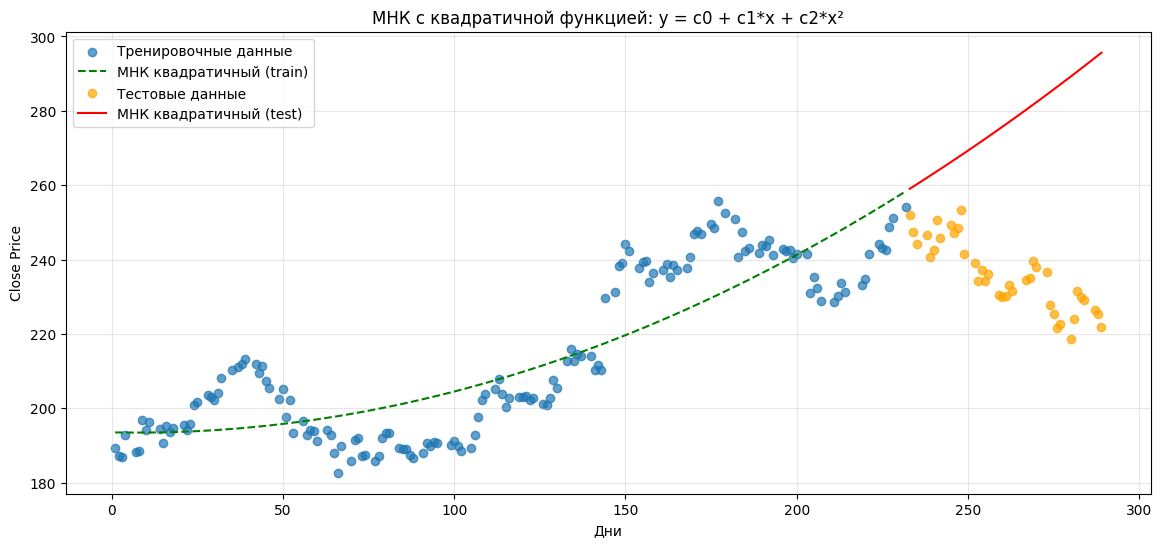

In [ ]:
X = data['x']
Y = data['Open']
X_poly = np.column_stack([X, X**2])

X_train, X_test, y_train, y_test = train_test_split(X_poly, Y, test_size=0.2, random_state=42, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Визуализация МНК с квадратичной функцией
plt.figure(figsize=(14, 6))

# Сортируем для красивого графика
train_sorted_idx = np.argsort(X_train[:, 0])
test_sorted_idx = np.argsort(X_test[:, 0])

plt.scatter(X_train[:, 0], y_train, label='Тренировочные данные', alpha=0.7)
plt.plot(X_train[train_sorted_idx, 0], model.predict(X_train)[train_sorted_idx],
         color='green', label='МНК квадратичный (train)', ls='dashed')
plt.scatter(X_test[:, 0], y_test, color='orange', label='Тестовые данные', alpha=0.7)
plt.plot(X_test[test_sorted_idx, 0], y_pred[test_sorted_idx],
         color='red', label='МНК квадратичный (test)')
plt.title('МНК с квадратичной функцией: y = c0 + c1*x + c2*x²')
plt.xlabel('Дни')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Метод SVM

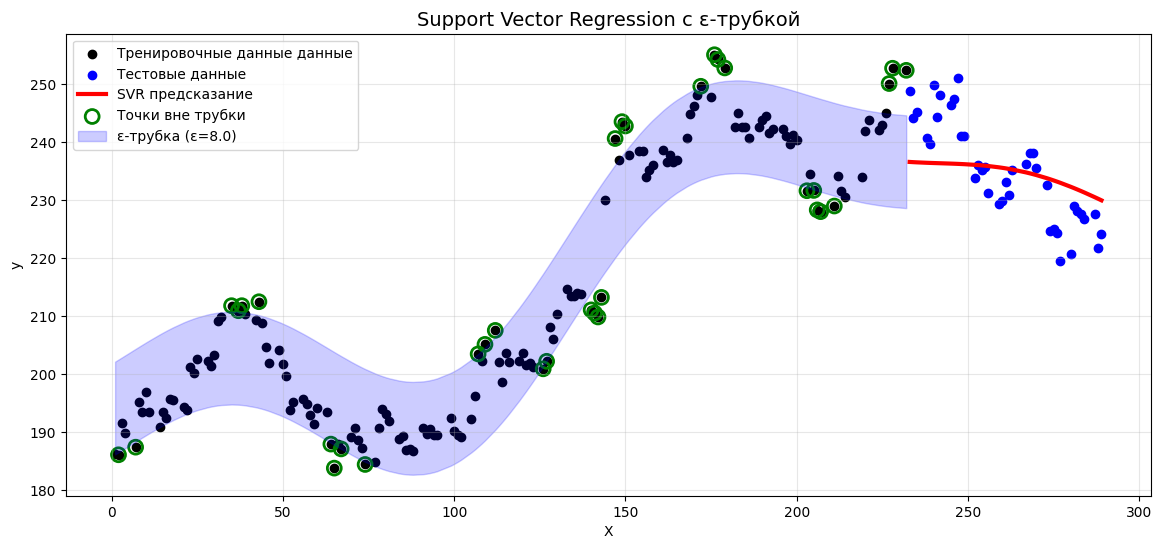

In [ ]:
x = np.array(X).reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2, random_state=42, shuffle=False)

epsilon = 8.0
svm_model = SVR(kernel='rbf', C=30, epsilon=epsilon)
svm_model.fit(x_train, y_train)

y_pred = svm_model.predict(x_test)

# Визуализация
plt.figure(figsize=(14, 6))
plt.scatter(x_train, y_train, label='Тренировочные данные данные', color='black')
plt.scatter(x_test, y_test, label='Тестовые данные', color='blue')
plt.plot(x_test, y_pred, color='red', lw=3, label='SVR предсказание')

# Выделим точки, вышедшие за трубку
y_pred_train = svm_model.predict(x_train)
outside_upper = y_train > (y_pred_train + epsilon)
outside_lower = y_train < (y_pred_train - epsilon)
outside = outside_upper | outside_lower

plt.scatter(x_train[outside], y_train[outside], facecolors='none', edgecolors='green', s=100, linewidth=2, label='Точки вне трубки')
# Границы трубки
y_upper = y_pred_train + epsilon
y_lower = y_pred_train - epsilon
plt.fill_between(x_train.ravel(), y_lower, y_upper, color='blue', alpha=0.2, label=f'ε-трубка (ε={epsilon})')

plt.title('Support Vector Regression с ε-трубкой', fontsize=14)
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Добавим ещё один параметр


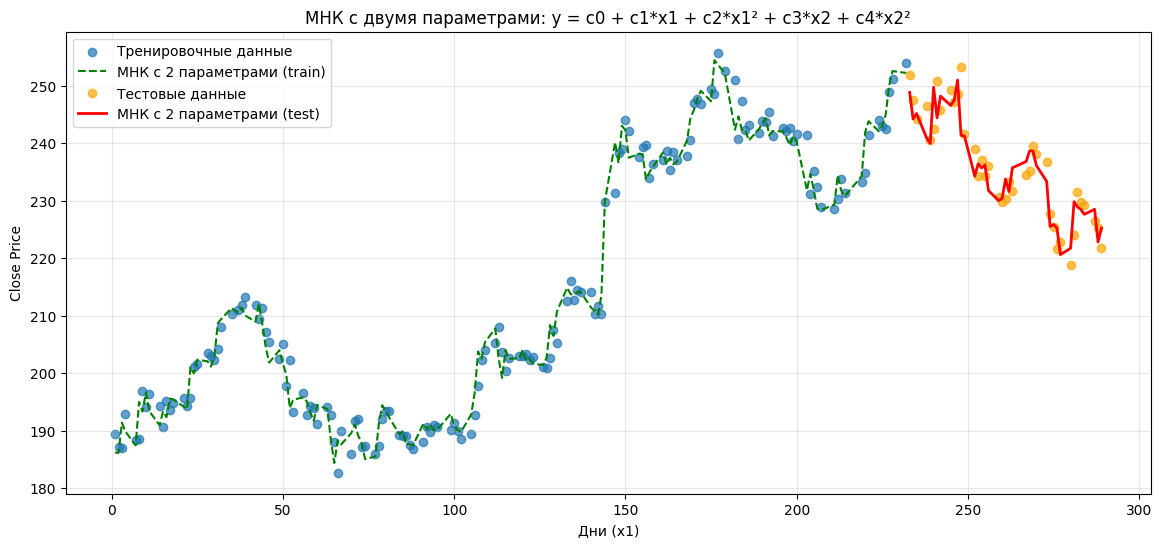

In [ ]:
x1 = data['x']
x2 = data['Close']
Y = data['Open']
X_poly_2_params = np.column_stack([x1, x2**2, x2, x2**2])

X_train_2p, X_test_2p, y_train_2p, y_test_2p = train_test_split(
    X_poly_2_params, Y, test_size=0.2, random_state=42, shuffle=False
)

model_2params = LinearRegression()
model_2params.fit(X_train_2p, y_train_2p)
y_pred_2params = model_2params.predict(X_test_2p)

# Визуализация МНК с двумя параметрами
plt.figure(figsize=(14, 6))

train_sorted_idx_2p = np.argsort(X_train_2p[:, 0])
test_sorted_idx_2p = np.argsort(X_test_2p[:, 0])

plt.scatter(X_train_2p[:, 0], y_train_2p, label='Тренировочные данные', alpha=0.7)
plt.plot(X_train_2p[train_sorted_idx_2p, 0], model_2params.predict(X_train_2p)[train_sorted_idx_2p],
         color='green', label='МНК с 2 параметрами (train)', ls='dashed')
plt.scatter(X_test_2p[:, 0], y_test_2p, color='orange', label='Тестовые данные', alpha=0.7)
plt.plot(X_test_2p[test_sorted_idx_2p, 0], y_pred_2params[test_sorted_idx_2p],
         color='red', label='МНК с 2 параметрами (test)', linewidth=2)
plt.title('МНК с двумя параметрами: y = c0 + c1*x1 + c2*x1² + c3*x2 + c4*x2²')
plt.xlabel('Дни (x1)')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

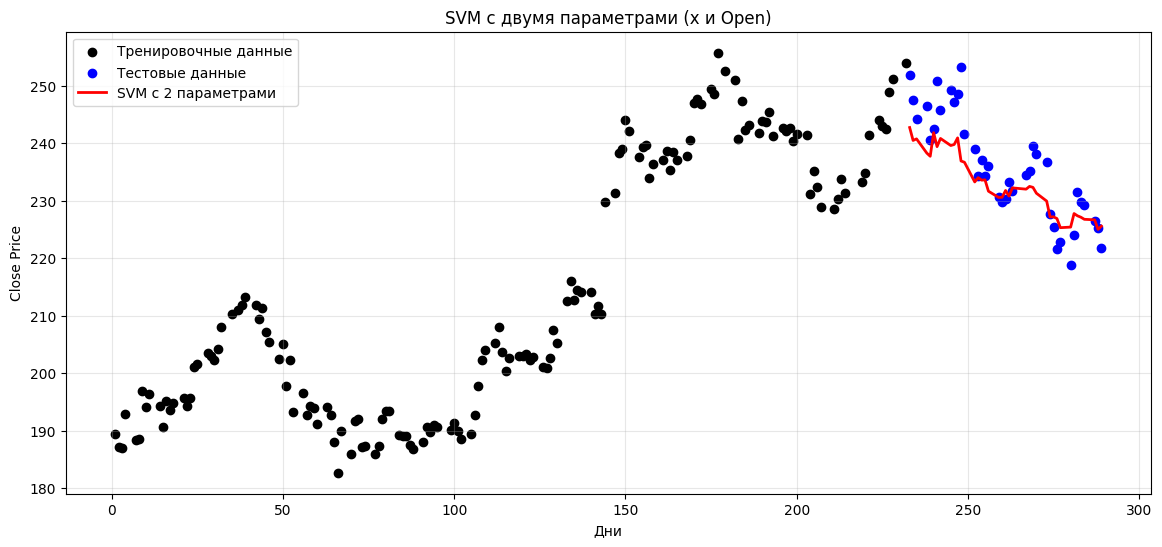

In [ ]:
# SVM с двумя параметрами
X_2params_svm = data[['x', 'Close']]
Y_svm = data['Open']
X_train_svm_2p, X_test_svm_2p, y_train_svm_2p, y_test_svm_2p = train_test_split(X_2params_svm, Y_svm, test_size=0.2, random_state=42, shuffle=False)

# SVM с двумя параметрами
epsilon_2p = 7.0
svm_model_2p = SVR(kernel='rbf', C=60, epsilon=epsilon_2p)
svm_model_2p.fit(X_train_svm_2p, y_train_svm_2p)

y_pred_svm_2p = svm_model_2p.predict(X_test_svm_2p)

# Визуализация SVM с двумя параметрами
plt.figure(figsize=(14, 6))

plt.scatter(X_train_svm_2p['x'], y_train_svm_2p, label='Тренировочные данные', color='black')
plt.scatter(X_test_svm_2p['x'], y_test_svm_2p, label='Тестовые данные', color='blue')
plt.plot(X_test_svm_2p['x'], y_pred_svm_2p, color='red', lw=2, label='SVM с 2 параметрами')

plt.title('SVM с двумя параметрами (x и Open)')
plt.xlabel('Дни')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()